# Preparing the Environment

O primeiro passo para o início de nossas análises é a instalação e preparação do ambiente de trabalho. Devemos instalar duas dependências:
- OpenCV
- PyTesseract

Para que o PyTesseract funcione corretamente, é necessário tê-lo instalado no computador. Para instalá-lo, consulte a página do [instalador](https://github.com/UB-Mannheim/tesseract/wiki). 

Além disso, é necessário importar o pacote de linguagem adequado para a língua portuguesa. Para isso, foi utilizado o comando ```curl``` que irá baixar os dados treinados para o diretório tessdata.

In [277]:
# Instalando dependências
!pip install opencv-python
!pip install pytesseract

# Preparando o modelo de linguagem
!mkdir tessdata
!curl -o ./tessdata/por.traineddata -L https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata

J  existe uma subpasta ou um arquivo tessdata.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 14.6M    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 14.6M  100 14.6M    0     0   9.8M      0  0:00:01  0:00:01 --:--:-- 27.8M


# Importing libraries

A etapa seguinte é importar as bibliotecas necessárias para o Python. 
- **Matplotlib** (plt) será usada para visualização das imagens;
- **OpenCV** (cv2) é usada para abertura e tratamento das imagens;
- **PyTesseract** representa a interface Python para o Tesseract-OCR

É também necessário informar ao PyTesseract o caminho (PATH) para o executável do Tesseract no seu sistema, de acordo com a instalação feita anteriormente. 

**OBS.:** Essa etapa foi necessária na utilização do Jupyter Notebook. Não é necessária no Google Colab.

In [278]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import pytesseract
from pytesseract import Output

# Configurando PATH para o Tesseract-OCR
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Test Image

A seguir, iremos abrir e exibir uma foto de uma placa veicular. Já iremos utilizar o método ```cvtColor``` (do ```cv2```) para converter o sistema de cores de BGR para **tons de cinza (GRAY)**. Isso é feito, pois, as técnicas aqui aplicadas futuramente necessitarão das imagens nesse sistema.

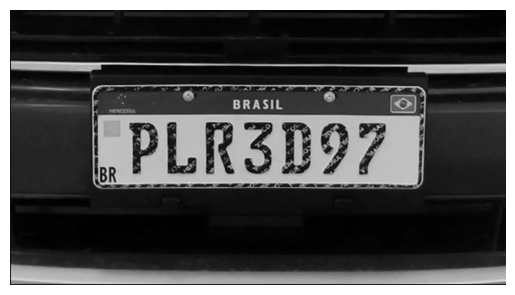

In [279]:
# Lendo a imagem com OpenCV
img = cv2.imread('license_plates/placa_carro1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Desativando os eixos e exibindo a imagem em tons de cinza
plt.axis('off')
plt.imshow(img, cmap=cm.gray, vmin=0, vmax=255);

Agora, aplicando a leitura de texto, a partir do PyTesseract, nessa imagem, vemos que a distinção dos caracteres ainda não é precisa.

In [280]:
config_tesseract = '--tessdata-dir tessdata --psm 6'
text = pytesseract.image_to_string(img, lang = 'por', config = config_tesseract)
print(text)

. PLRSD97 |
o



As próximas etapas serão a aplicação de técnicas para o tratamento das imagens, visando uma leitura mais precisa das informações presentes nas imagens.

# Simple Thresholding

A **limiarização** é um dos processos mais simples de **segmentação de imagens**, se baseia na intensidade de cor dos pixels para realizar uma transformação. Em uma imagem em escala de cinza, a partir de um valor denominado limiar, os pixels da imagem serão segmentados em dois grupos: o grupo de pixels com intensidade de cinza abaixo do limiar e o grupo de pixels com intensidade de cinza acima do limiar. Esse limiar pode ser definido globalmente, servindo para todos os pixels da imagem simultaneamente, ou localmente, onde cada região da imagem terá um limiar diferente.

Nesta seção, vamos iterar diferentes valores para o limiar (threshold), aplicando o método  ```THRESH_BINARY```. Para isso, criarei uma lista com três valores escolhidos.

A limiarização do tipo ```THRESH_BINARY``` dividirá, de acordo com um valor (entre 0 a 255, ou seja, um tom de cinza) a imagem em somente duas cores, preta e branca.

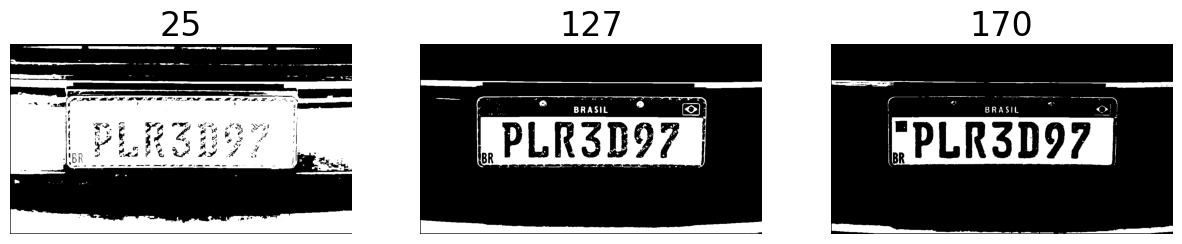

In [281]:
thresh = []
thresholds = [25, 127, 170]

for threshold in thresholds:
    _,img_copy = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    thresh.append(img_copy)

plt.figure(figsize=(15, 5))
    
for i in range(len(thresh)):
    plt.subplot(1,3,i+1)
    plt.imshow(thresh[i],cmap=cm.gray, vmin=0, vmax=255)
    plt.title(str(thresholds[i]), fontsize=24)
    plt.axis('off')

É fácil perceber que a imagem com threshold (limiar) de 170, apresenta uma clareza muito superior àquela com valor de 25. No entanto, repare que o processo de limiarização (ou, thresholding) é extremamente manual, tendo que ser selecionado um valor numérico para cada imagem diferente. 

Deve-se ainda ressaltar que, nem todas as imagens terão uma iluminação homogênea, então, diferentes regiões delas podem exigir diferentes valores de threshold - portanto, este é mais um ponto negativo da limiarização simples.

In [282]:
config_tesseract = '--tessdata-dir tessdata'
text = pytesseract.image_to_data(thresh[2], lang='por', config=config_tesseract, output_type=Output.DICT)
text['text'][22]

'PLR3D97'

Ao extrair o texto da placa e filtrá-lo, foi possível identificar corretamente o texto contido na imagem. No entanto, a filtragem foi completamente manual!

# Adaptative Thresholding

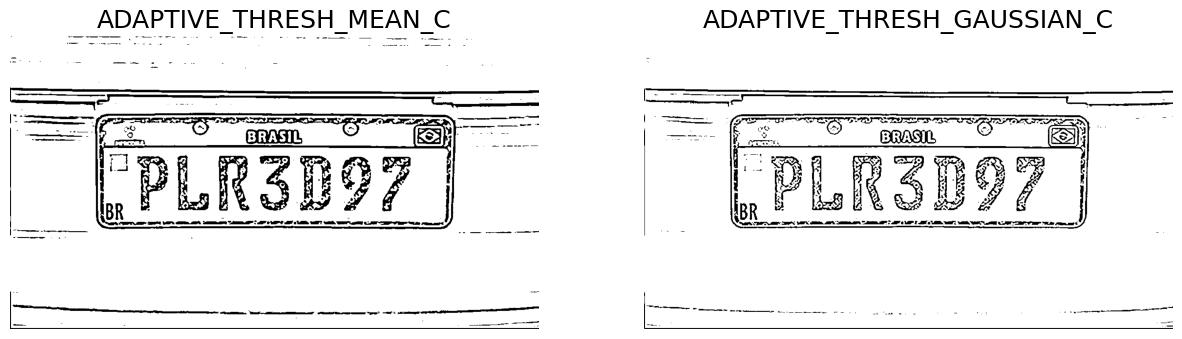

In [283]:
# Definindo o tamanho das figuras
plt.figure(figsize=(15, 5))

# Gerando imagem pelo método ADAPTIVE_THRESH_MEAN_C
plt.subplot(1,2,1)
plt.axis('off')
lim_adapt1 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 8)
plt.imshow(lim_adapt1,cmap=cm.gray, vmin=0, vmax=255)
plt.title('ADAPTIVE_THRESH_MEAN_C', fontsize=18)

# Gerando imagem pelo método ADAPTIVE_THRESH_GAUSSIAN_C
plt.subplot(1,2,2)
plt.axis('off')
lim_adapt2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 8)
plt.imshow(lim_adapt2,cmap=cm.gray, vmin=0, vmax=255)
plt.title('ADAPTIVE_THRESH_GAUSSIAN_C', fontsize=18);

Esse tratamento não foi interessante na questão da identificação dos caracteres. Mas, essa imagem destaca de forma mais clara as bordas contidas na imagem. Utilizando o método de limiarização ```ADAPTIVE_THRESH_GAUSSIAN_C``` obtivémos um resultado bastante semelhante ao ```ADAPTIVE_THRESH_MEAN_C```, no entanto, esse método conseguiu eliminar parte dos ruidos na imagem.

# Otsu's Binarization

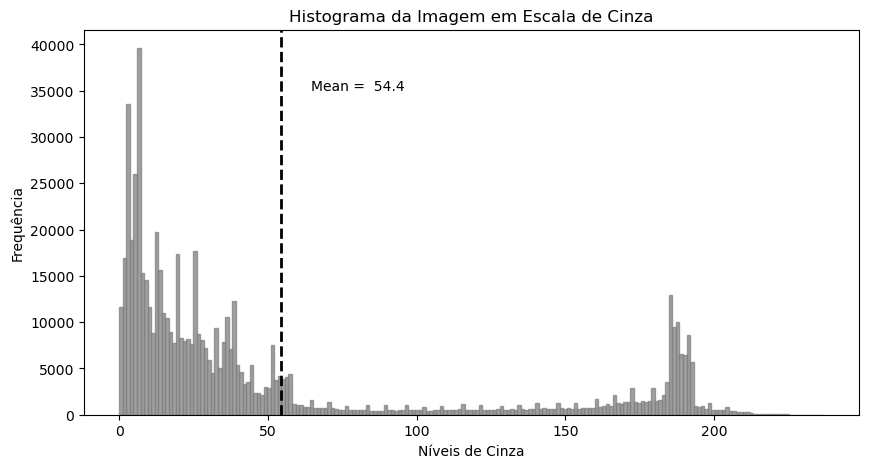

In [284]:
plt.figure(figsize=(10, 5))
plt.title('Histograma da Imagem em Escala de Cinza')
plt.xlabel('Níveis de Cinza')
plt.ylabel('Frequência')
plt.axvline(img.mean(), color='black', linestyle='dashed', linewidth=2, label='Média')
plt.text(img.mean()+10, 35000, f'Mean = {img.mean(): .1f}', color='black', fontsize=10)
plt.hist(img.flatten(), bins=200, color='gray', alpha=0.75, edgecolor='gray');

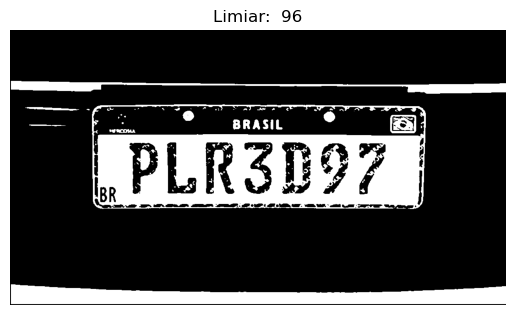

In [285]:
value, lim_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(lim_otsu, cmap=cm.gray, vmin=0, vmax=255)
plt.title(f'Limiar: {value: .0f}')
plt.axis('off');

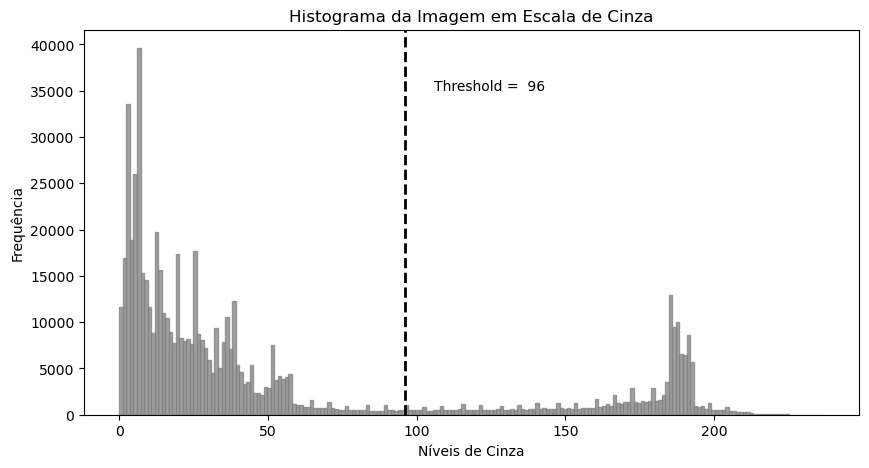

In [286]:
plt.figure(figsize=(10, 5))
plt.title('Histograma da Imagem em Escala de Cinza')
plt.xlabel('Níveis de Cinza')
plt.ylabel('Frequência')
plt.axvline(value, color='black', linestyle='dashed', linewidth=2, label='Média')
plt.text(value+10, 35000, f'Threshold = {value: .0f}', color='black', fontsize=10)
plt.hist(img.flatten(), bins=200, color='gray', alpha=0.75, edgecolor='gray');

Agora, extraindo o texto dessa imagem

In [287]:
config_tesseract = '--tessdata-dir tessdata'
text = pytesseract.image_to_string(lim_otsu, lang='por', config=config_tesseract)
print(text)

Apesar do tratamento da imagem, a partir da binariazação de Otsu, nos fornecer um limiar de maneira automática, somente com esse tratamento não foi possível identificar o texto da placa. 

# Morphological Transformations 

## 1. Erosion

> A ideia básica da erosão é semelhante à erosão do solo. Ela desgasta as fronteiras do objeto em primeiro plano (sempre tente manter o primeiro plano em branco). Então, o que ela faz? O kernel desliza pela imagem (como na convolução 2D). Um pixel na imagem original (seja 1 ou 0) será considerado 1 apenas se todos os pixels sob o kernel forem 1; caso contrário, ele é erodido (tornado zero).

> Então, o que acontece é que todos os pixels próximos à borda serão descartados dependendo do tamanho do kernel. Assim, a espessura ou tamanho do objeto em primeiro plano diminui, ou simplesmente a região branca diminui na imagem. Isso é útil para remover pequenos ruídos brancos (como vistos no capítulo de espaço de cores), separar dois objetos conectados, entre outros usos.

Fonte: [Morphological Transformations](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html)

In [288]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))

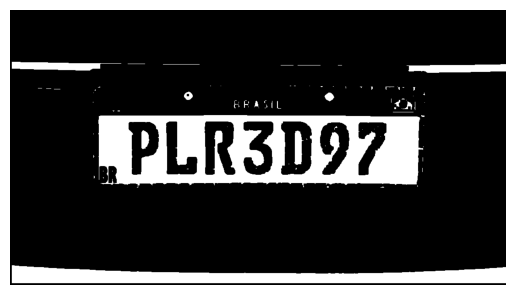

In [289]:
erosion = cv2.erode(lim_otsu, kernel)
plt.axis('off')
plt.imshow(erosion, cmap=cm.gray, vmin=0, vmax=255);

Nesse caso, por conta da presença de ruídos na imagem, deixados pela binarização de Otsu, na cor branca, foi possível obter um excelente resultado. Pois, a cor preta expandiu, minimizando as regiões com falhas em branco.

In [290]:
config_tesseract = '--tessdata-dir tessdata'
text = pytesseract.image_to_data(erosion, lang='por', config=config_tesseract, output_type=Output.DICT)
text['text'][-1]

'PLR3D97'

## 2. Dilatation

No caso da dilatação, teremos o efeito oposto ao da erosão. As regiões em branco irão expandir, ao invés das regiões em preto.

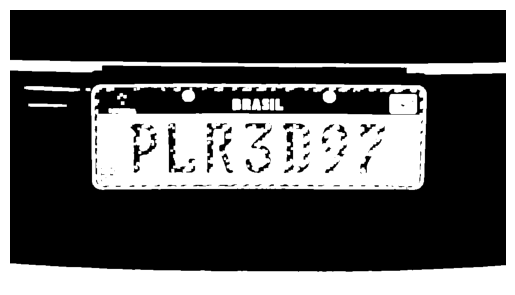

In [291]:
dilatation = cv2.dilate(lim_otsu, kernel)
plt.axis('off')
plt.imshow(dilatation, cmap=cm.gray, vmin=0, vmax=255);

Para o nosso caso, ela não foi útil, mas, para análises posteriores, pode vir a ser... 

## 3. Opening

> **Abertura** é somente outro nome para a erosão seguida de dilatação. Ela é útil para remover ruídos. Ela pode ser usada a partir da função ```cv2.morphologyEx()```.

O processo de erosão irá remover pequenos ruídos brancos na imagem. Dessa forma, alguns deles serão completamente sobrepostos pela cor preta. Ao dilatar, a imagem voltará à proporção inicial (antes da erosão) e esses pequenos ruídos terão sido eliminados. 

Vou aplicar os três procedimentos para comparação.

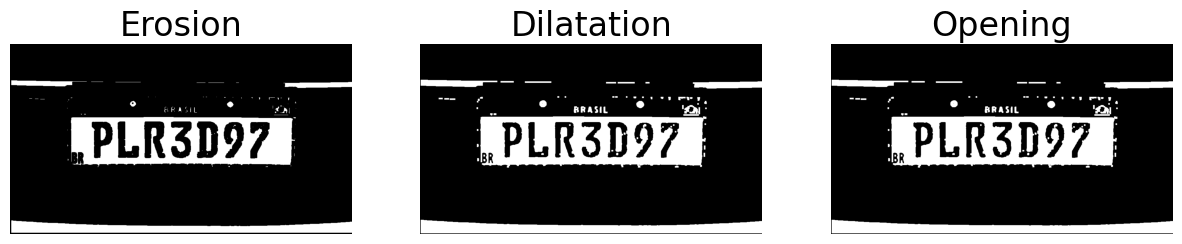

In [292]:
# Definindo o tamanho das figuras
plt.figure(figsize=(15, 5))

# Erosão
plt.subplot(1,3,1)
erosion = cv2.erode(lim_otsu, kernel)
plt.axis('off')
plt.title('Erosion', fontsize=24)
plt.imshow(erosion, cmap=cm.gray, vmin=0, vmax=255);

# Dilatação
plt.subplot(1,3,2)
dilatation = cv2.dilate(erosion, kernel)
plt.axis('off')
plt.title('Dilatation', fontsize=24)
plt.imshow(dilatation, cmap=cm.gray, vmin=0, vmax=255);

# Abertura
plt.subplot(1,3,3)
opening = cv2.morphologyEx(lim_otsu, cv2.MORPH_OPEN, kernel)
plt.axis('off')
plt.title('Opening', fontsize=24)
plt.imshow(opening, cmap=cm.gray, vmin=0, vmax=255);


Dessa forma, fica clara a comparação descrita anteriormente. A imagem obtida pela erosão é um pouco distorcida em relação à imagem original, enquanto as outras duas imagens têm a mesma proporção e são idênticas.

## 4. Closing

> **Fechamento** é a operação reversa da **abertura**, ou seja, é a dilatação seguida da erosão. Ela é útil para fechar pequenos buracos pretos na imagem.

Como nossa imagem apresenta ruídos brancos, ela não será muito útil, mas farei uma demonstração.

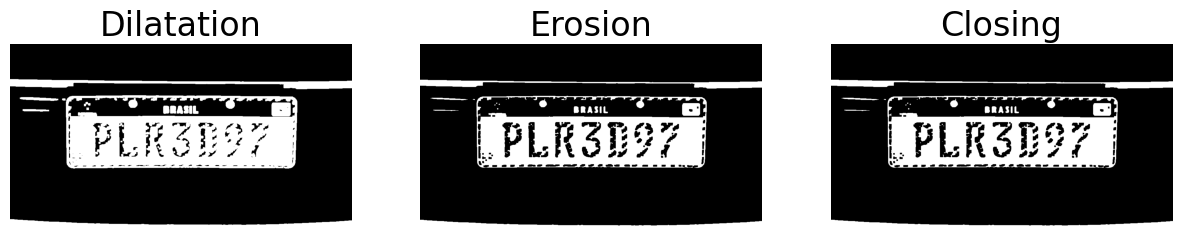

In [293]:
# Definindo o tamanho das figuras
plt.figure(figsize=(15, 5))

# Dilatação
plt.subplot(1,3,1)
dilatation = cv2.dilate(lim_otsu, kernel)
plt.axis('off')
plt.title('Dilatation', fontsize=24)
plt.imshow(dilatation, cmap=cm.gray, vmin=0, vmax=255);

# Erosão
plt.subplot(1,3,2)
erosion = cv2.erode(dilatation, kernel)
plt.axis('off')
plt.title('Erosion', fontsize=24)
plt.imshow(erosion, cmap=cm.gray, vmin=0, vmax=255);

# Fechamento
plt.subplot(1,3,3)
closing = cv2.morphologyEx(lim_otsu, cv2.MORPH_CLOSE, kernel)
plt.axis('off')
plt.title('Closing', fontsize=24)
plt.imshow(closing, cmap=cm.gray, vmin=0, vmax=255);


## 5. Other Transformations

Existem ainda outras transformações, que podem ser encontradas na documentação do [OpenCV](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html), são elas: 
- **Morphological Gradient**, que destaca o contorno das regiões em branco (é a diferença entre a dilatação e a erosão.
- **Top Hat**, destaca regiões claras em fundos escuros.
- **Black Hat**, que destaca regiões escuras em fundos claros.

# Edges and Contours

Usaremos o algoritmo detector de bordas para isolar a placa do carro, de maneira a suprimir os possíveis ruídos da imagem, em seguida, aplicaremos uma série de tratamentos e algoritmos para extrair de forma precisa o texto da placa veicular.

> O **detector de bordas de Canny** é um algoritmo bastante complexo para detectar os contornos dos objetos em uma imagem e passa por uma série de etapas até chegar ao resultado da transformação.

> O primeiro passo é a redução de ruídos. Nesse sentido, a detecção de bordas é muito suscetível a ruídos na imagem, que podem interferir na detecção dos objetos de interesse na figura. Inicialmente, é aplicado um filtro de desfoque (GaussianBlur) na imagem para reduzir os ruídos.

> O segundo passo é encontrar a intensidade do gradiente na imagem: O gradiente na imagem é a diferença de intensidade de cor em uma determinada direção. O cálculo do gradiente é feito com base na direção horizontal e vertical da figura através de um algoritmo chamado Sobel.

> O terceiro passo é fazer uma supressão, pois uma vez feito o cálculo do gradiente, um escaneamento será feito na figura pixel a pixel, checando em cada um dos pixels se o gradiente é o maior valor dentro de uma vizinhança próxima. Caso o pixel tenha uma magnitude do gradiente máxima localmente, este é escolhido como uma borda. Isso resulta em uma imagem com bordas finas dos objetos.

> O último passo consiste em fazer um limite de histerese – a histerese é a tendência de um sistema de conservar suas propriedades –, esse passo decidirá quais bordas serão realmente contornos e quais não serão. São escolhidos, portanto, dois valores de limiar: um limiar mínimo e um máximo. Qualquer contorno que tenha uma intensidade de gradiente maior que o limite máximo é mantido como borda. Aqueles que tiverem uma intensidade menor que o limite mínimo serão descartados. Os pixels que tiverem uma gradiente entre os valores mínimo e máximo são mantidos somente se estiverem conectados continuamente a um pixel com gradiente maior que o limite máximo.

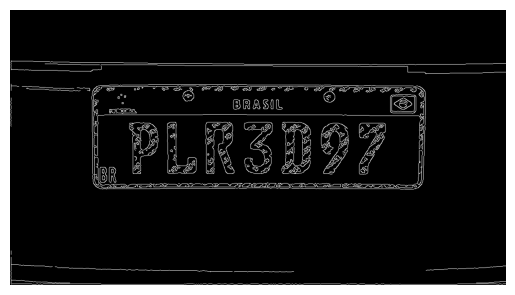

In [294]:
edges = cv2.Canny(img, 100, 200)
plt.axis('off')
plt.imshow(edges, cmap=cm.gray, vmin=0, vmax=255);

Na imagem acima, podemos ver que extraímos somente as bordas presentes na imagem. O próximo passo é identificar os contornos, aproximando-os por meio de polígonos e encontrar aquele que mais se aproxima do formato da placa veicular - no caso, um quadrilátero (4 vértices). 

In [295]:
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    if cv2.isContourConvex(approx) and len(approx) == 4:
        location = approx
        break

Uma vez encontrado o contorno, podemos delimitar a imagem usando o método ```boundingRect()``` da biblioteca OpenCV - que retornará o vértice, comprimento e altura do polígono.

In [296]:
x, y, w, h = cv2.boundingRect(location)

In [297]:
print(f'Vértice: ({x},{y}), Comprimento: {w} e Altura: {h}')

Vértice: (180,168), Comprimento: 722 e Altura: 224


Uma vez obtida a caixa delimitadora, pode-se filtrá-la na imagem efetuando "cortes" na matrix da imagem original.

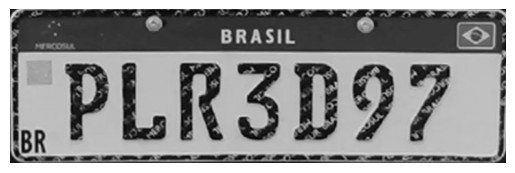

In [298]:
license_plate = img[y:y+h, x:x+w]
plt.axis('off')
plt.imshow(license_plate, cmap=cm.gray, vmin=0, vmax=255);

Com a placa em evidência, pode-se usar a erosão para destacar as letras presentes na placa, conforme vimos na seção de transformações morfológicas.

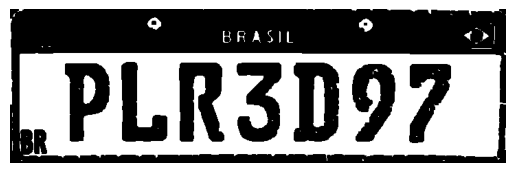

In [299]:
threshold, lim_otsu = cv2.threshold(license_plate, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
erosion = cv2.erode(lim_otsu, cv2.getStructuringElement(cv2.MORPH_RECT, (4,4)))
plt.axis('off')
plt.imshow(erosion, cmap=cm.gray, vmin=0, vmax=255);

Agora, aplicarei o Tesseract para extrair o texto da placa.

In [300]:
config_tesseract = '--tessdata-dir tessdata --psm 6'
text = pytesseract.image_to_string(erosion, lang='por', config=config_tesseract)
print(text)

L PLR3D97



Repare que o texto foi lido de maneira correta, no entanto, um caractere 'L' foi lido também, por conta da escrita 'BR' presente na placa. Para eliminá-lo, podemos filtrar o texto que se adequa ao padrão das placas veiculares. Ou seja, aplicar uma **expressão regular** (**Regex**).

In [301]:
import re
extracted_text = re.search('\w{3}\d{1}\w{1}\d{2}', text)
print(extracted_text.group(0))

PLR3D97


Dessa forma, aplicamos o processo de maneira automática do início ao fim, além de adquirir de forma precisa o texto da placa veicular.

# Application in another scenario

Uma vez que o cenário anterior foi aplicado de forma automática. Podemos extrapolá-lo para outro cenário, buscando reconhecer o texto da placa veicular. Para isso, repetiremos o mesmo passo a passo feito na seção anterior - mas, para outra imagem.

Importando a imagem, convertendo-a para tons de cinza e exibindo-a.

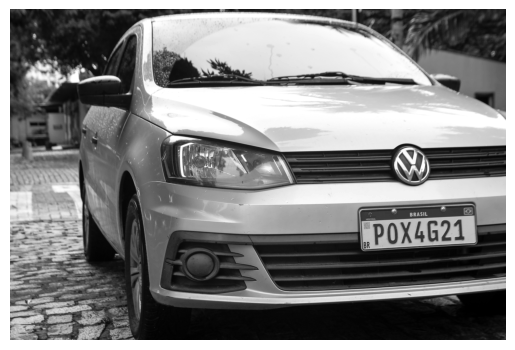

In [302]:
# Lendo a imagem com OpenCV
img = cv2.imread('license_plates/placa_carro2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Desativando os eixos e exibindo a imagem em tons de cinza
plt.axis('off')
plt.imshow(img, cmap=cm.gray, vmin=0, vmax=255);

Identificando as bordas e contornos da placa

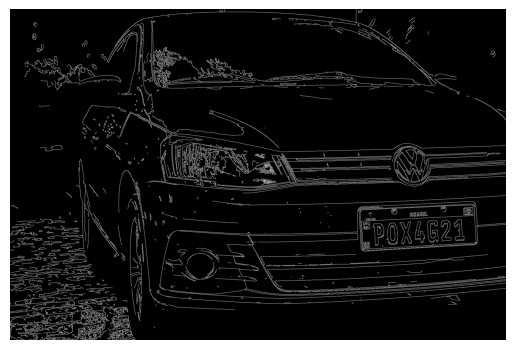

In [303]:
edges = cv2.Canny(img, 100, 200)
plt.axis('off')
plt.imshow(edges, cmap=cm.gray, vmin=0, vmax=255);

Repare que, nesse caso, temos muito mais contornos que no anterior. Com isso, teremos que filtrar de maneira mais apropriada os contornos com base na área dos polígonos. Para isso, selecionaremos os dez contornos de maior área, utilizando a função ```sorted()```.

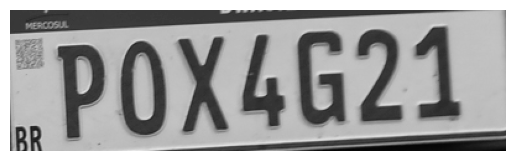

In [304]:
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

for contour in contours:
    
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    if cv2.isContourConvex(approx) and len(approx) == 4:
        location = approx
        break
        
x, y, w, h = cv2.boundingRect(location)

license_plate = img[y:y+h, x:x+w]
plt.axis('off')
plt.imshow(license_plate, cmap=cm.gray, vmin=0, vmax=255);

Agora, com a placa identificada, podemos continuar o procedimento normalmente.

Aplicando a binarização de Otsu na imagem, destacaremos os caracteres.

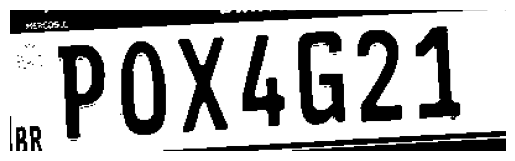

In [305]:
threshold, lim_otsu = cv2.threshold(license_plate, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.axis('off')
plt.imshow(lim_otsu, cmap=cm.gray, vmin=0, vmax=255);

Agora, aplicando o Tesseract para o processamento do texto.

In [306]:
config_tesseract = '--tessdata-dir tessdata --psm 6'
text = pytesseract.image_to_string(lim_otsu, lang='por', config=config_tesseract)
print(text)

“POX4G21



Aplicando a expressão regular, para filtrar o texto correto.

In [307]:
import re
extracted_text = re.search('\w{3}\d{1}\w{1}\d{2}', text)
print(extracted_text.group(0))

POX4G21


Conseguimos identificar o código da placa veicular corretamente, porém, tivémos que adaptar algumas coisas, como: seleção da placa e utilizar somente a binarização de Otsu. Isso significa que esse procedimento não funcionará para 100% dos casos.

# Automatic recognition

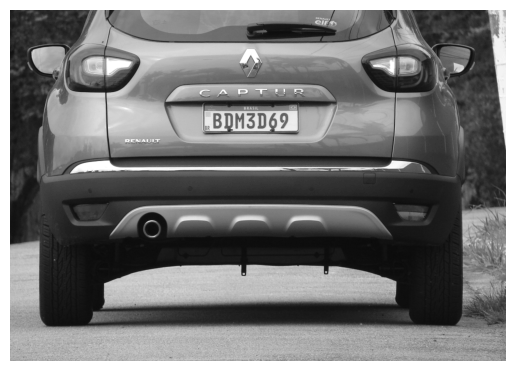

In [308]:
# Lendo a imagem com OpenCV
img = cv2.imread('license_plates/placa_carro3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Desativando os eixos e exibindo a imagem em tons de cinza
plt.axis('off')
plt.imshow(img, cmap=cm.gray, vmin=0, vmax=255);

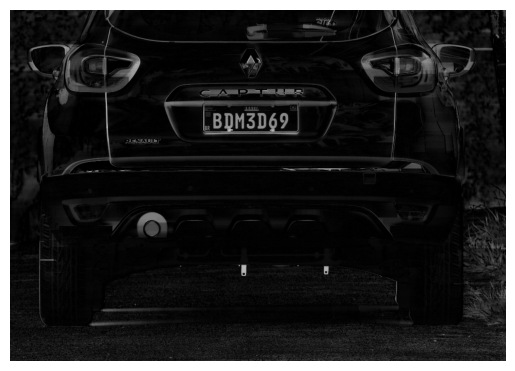

In [309]:
kernel_rect = cv2.getStructuringElement(cv2.MORPH_RECT, (40,13))
black_hat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel_rect)
plt.axis('off')
plt.imshow(black_hat, cmap=cm.gray, vmin=0, vmax=255);

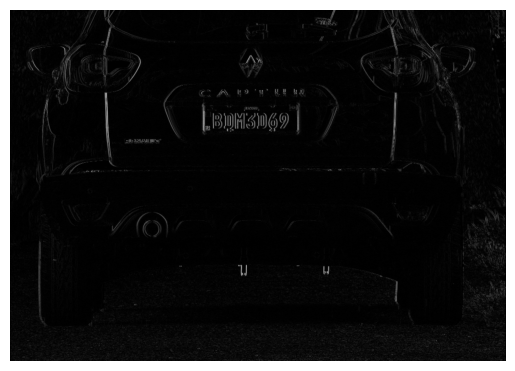

In [310]:
import numpy as np

sobel_x = cv2.Sobel(black_hat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=1)
sobel_x = np.absolute(sobel_x)
sobel_x = sobel_x.astype('uint8')

plt.axis('off')
plt.imshow(sobel_x, cmap=cm.gray, vmin=0, vmax=255);

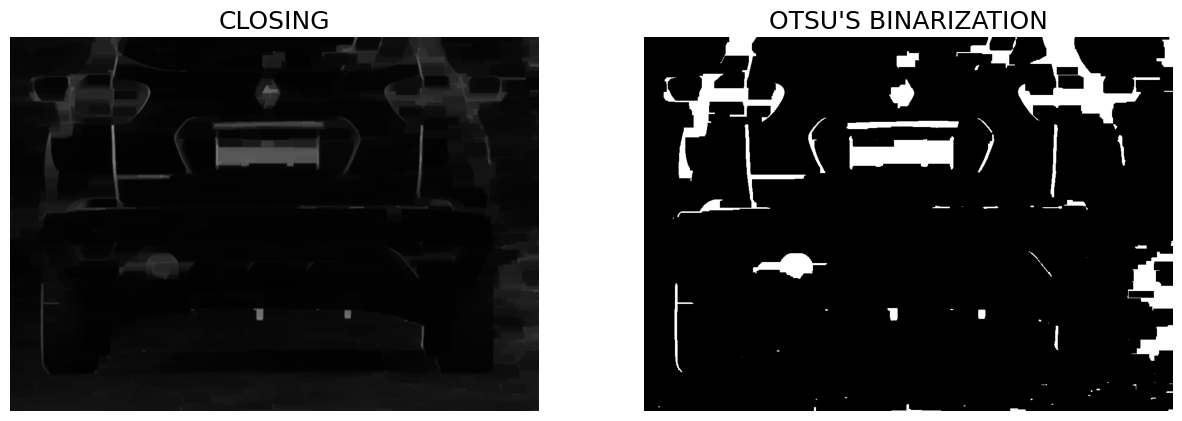

In [311]:
sobel_x = cv2.GaussianBlur(sobel_x, (5,5), 0)
sobel_x = cv2.morphologyEx(sobel_x, cv2.MORPH_CLOSE, kernel_rect)

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.axis('off')
plt.title('CLOSING', fontsize=18)
plt.imshow(sobel_x, cmap=cm.gray, vmin=0, vmax=255);

_, threshold = cv2.threshold(sobel_x, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

plt.subplot(1,2,2)
plt.axis('off')
plt.title("OTSU'S BINARIZATION", fontsize=18)
plt.imshow(threshold, cmap=cm.gray, vmin=0, vmax=255);


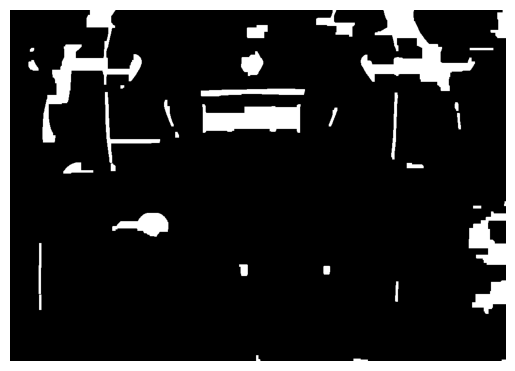

In [312]:
kernel_square = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
erosion = cv2.erode(threshold, kernel_square, iterations=2)
dilatation = cv2.dilate(erosion, kernel_square, iterations=2)

plt.axis('off')
plt.imshow(dilatation, cmap=cm.gray, vmin=0, vmax=255);

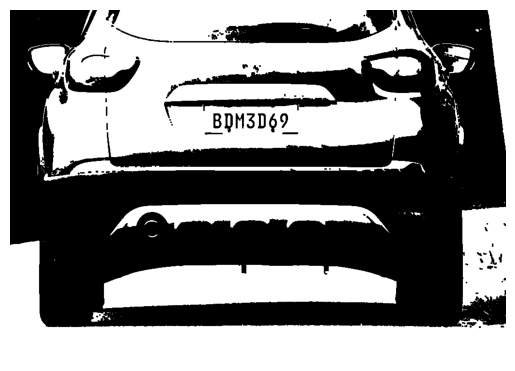

In [313]:
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_square)
_, mask = cv2.threshold(closing, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.axis('off')
plt.imshow(mask, cmap=cm.gray, vmin=0, vmax=255);

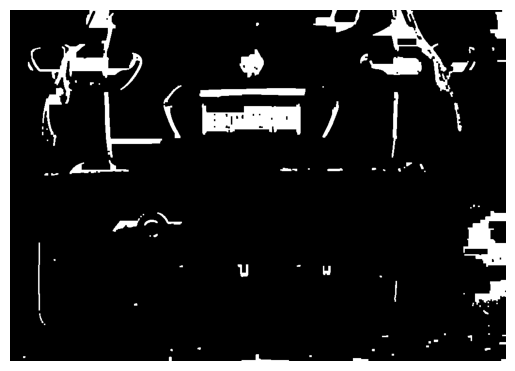

In [314]:
threshold = cv2.bitwise_and(threshold, threshold, mask=mask)
threshold = cv2.dilate(threshold, kernel_square, iterations=2)
threshold = cv2.erode(threshold, kernel_square)

plt.axis('off')
plt.imshow(threshold, cmap=cm.gray, vmin=0, vmax=255);

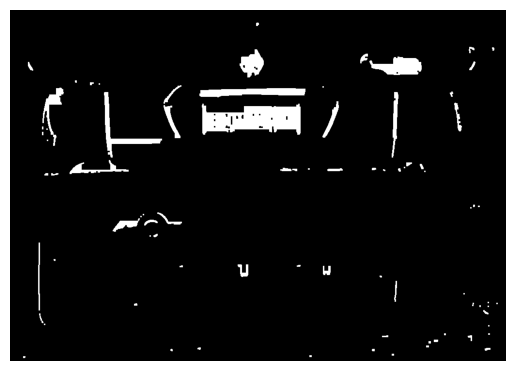

In [315]:
from skimage.segmentation import clear_border
threshold = clear_border(threshold)

plt.axis('off')
plt.imshow(threshold, cmap=cm.gray, vmin=0, vmax=255);

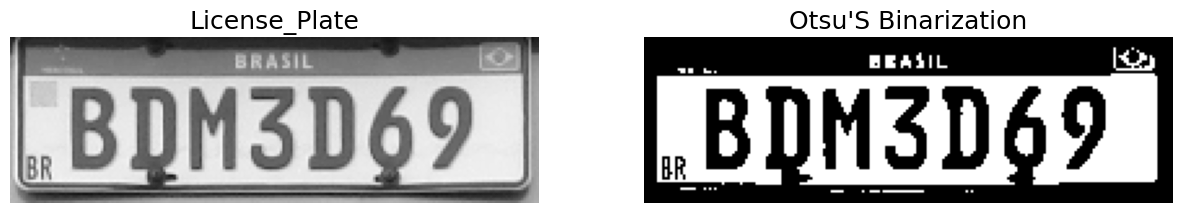

In [318]:
contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    ratio = float(w)/h
    if ratio >= 3 and ratio <= 3.5:
        license_plate = img[y:y+h, x:x+w]
        break

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('License_Plate', fontsize=18)
plt.imshow(license_plate, cmap=cm.gray, vmin=0, vmax=255);

_, location = cv2.threshold(license_plate, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
location = clear_border(location)

plt.subplot(1,2,2)
plt.axis('off')
plt.title("Otsu'S Binarization", fontsize=18)
plt.imshow(location, cmap=cm.gray, vmin=0, vmax=255);


In [320]:
config_tesseract = '--tessdata-dir tessdata --psm 6'
text = pytesseract.image_to_string(location, lang='por', config=config_tesseract)
print(text)

. BDM3D69 |



In [321]:
import re
extracted_text = re.search('\w{3}\d{1}\w{1}\d{2}', text)
print(extracted_text.group(0))

BDM3D69
